In [1]:
import warnings

warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import scipy.sparse as sparse
import seaborn as sns

sc.logging.print_header()
# sc.logging.print_versions()
sc.set_figure_params(facecolor="white", figsize=(8, 8))
sc.settings.verbosity = 3  # errors (0), warnings (1), info (2), hints (3)

sns.set_style("white")

np.random.seed(0)

scanpy==1.9.6 anndata==0.10.3 umap==0.5.4 numpy==1.26.0 scipy==1.11.3 pandas==2.1.3 scikit-learn==1.3.2 statsmodels==0.14.0 igraph==0.11.2 louvain==0.8.1 pynndescent==0.5.11


In [2]:
adata = sc.read_h5ad('D:/st_projects/data/osmFISH/osmFISH_cortex.h5ad')
adata.X = sparse.csr_matrix(adata.X)
# adata = adata[adata.obs['Region']!='Excluded']
adata

AnnData object with n_obs × n_vars = 5328 × 33
    obs: 'ClusterName', 'ClusterID', 'Region'
    uns: 'ClusterName_colors'
    obsm: 'spatial'

In [3]:
# banksy preprocess
from sklearn.neighbors import NearestNeighbors

visualize_weights = True
# KNN里邻居的数量
num_neighbours = 8
sigmas = (-1, )

nbrs = NearestNeighbors(algorithm='ball_tree').fit(adata.obsm['spatial'])
distances, indices = nbrs.kneighbors(n_neighbors=num_neighbours)
median_cell_distance = np.median(distances)
print(f"\nMedian distance to closest cell = {median_cell_distance}")
distances.shape, indices.shape


Median distance to closest cell = 366.00855127543286


((5328, 8), (5328, 8))

Maximum weight: 0.125


(-1194.779296875, 25090.365234375, -2414.51171875, 50704.74609375)

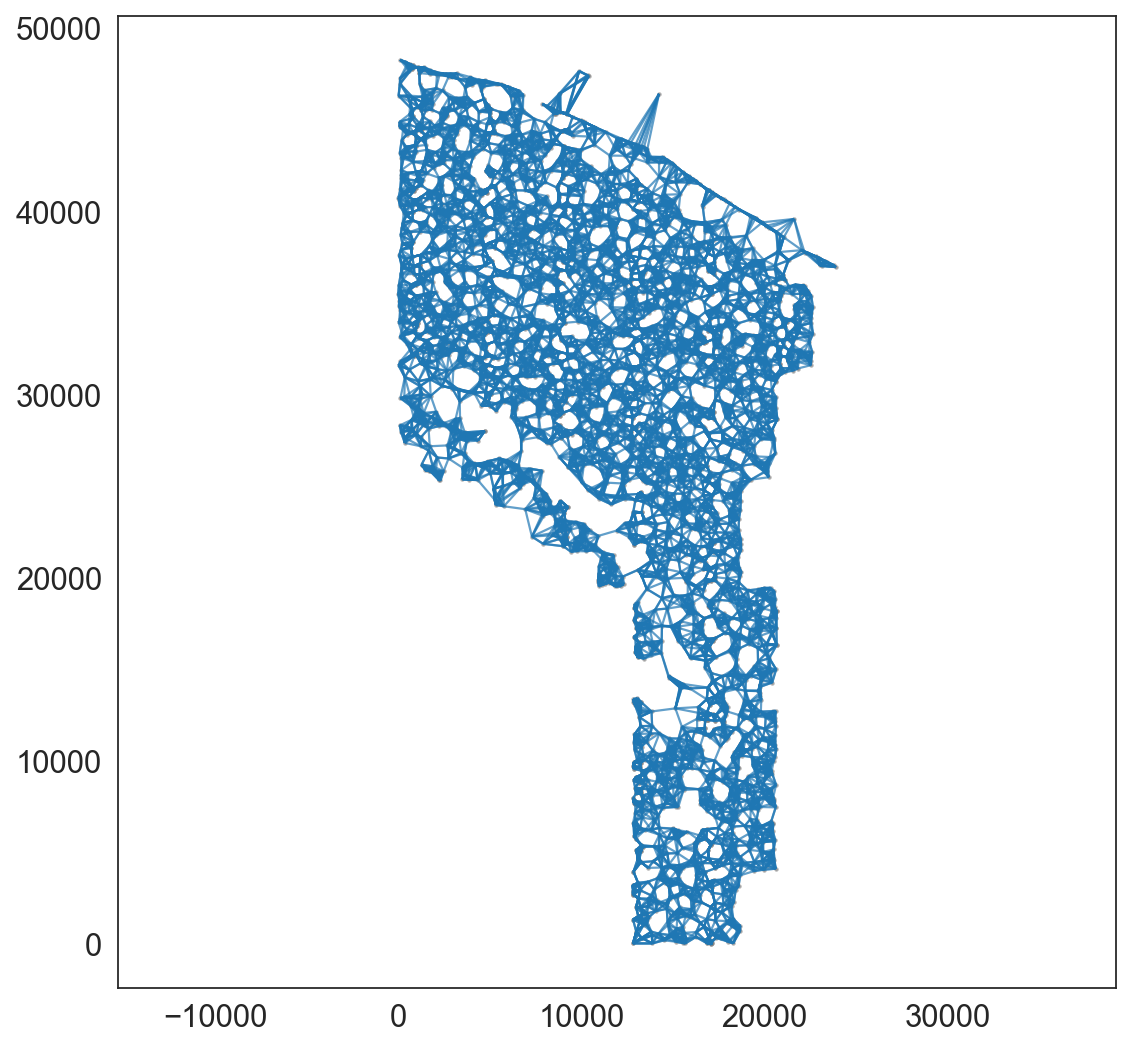

In [4]:
from utils import generate_spatial_weights_fixed_nbrs, plot_graph_weights

weights_graph, distance_graph = generate_spatial_weights_fixed_nbrs(adata.obsm['spatial'], num_neighbours=num_neighbours, decay_type='uniform', nbr_object=nbrs, verbose=False)
position = adata.obsm['spatial'].copy()
plot_graph_weights(position, sparse.csr_matrix(np.nan_to_num(weights_graph.A)), max_weight=1, markersize=1, figsize=(8, 8))
ax = plt.gca()
ax.axis('equal')

In [5]:
from utils import weighted_concatenate, zscore, matrix_to_adata

gene_list = adata.var.index

nbrhood_contribution = 0.8

neighbour_agg_matrix = weights_graph @ adata.X

if sparse.issparse(adata.X):
    concatenated = sparse.hstack((adata.X, neighbour_agg_matrix), )
else:
    concatenated = np.concatenate((adata.X, neighbour_agg_matrix), axis=1,)

matrix = weighted_concatenate(zscore(adata.X, axis=0), zscore(neighbour_agg_matrix, axis=0), nbrhood_contribution)


if sparse.issparse(matrix):
    st_dev_pergene = matrix.toarray().std(axis=0)
else:
    st_dev_pergene = matrix.std(axis=0)

enhanced_data = matrix_to_adata(matrix, adata)
display(enhanced_data)

num_nbrs: 33


AnnData object with n_obs × n_vars = 5328 × 66
    obs: 'ClusterName', 'ClusterID', 'Region'
    var: 'is_nbr'
    uns: 'ClusterName_colors'
    obsm: 'spatial'

In [6]:
sc.pp.pca(enhanced_data, n_comps=30)
low_dim_x = enhanced_data.obsm['X_pca']

computing PCA
    with n_comps=30
    finished (0:00:00)


In [7]:
from sklearn.metrics.pairwise import cosine_similarity

n_spot = low_dim_x.shape[0]
n_neighbor = 15
init_W = cosine_similarity(low_dim_x)
cos_init = np.zeros((n_spot, n_spot))
for i in range(n_spot):
    vec = init_W[i, :]
    distance = vec.argsort()[:: -1]
    for t in range(n_neighbor + 1):
        y = distance[t]
        cos_init[i, y] = init_W[i, y]

In [8]:
from MNMST_gpu import sparse_self_representation_torch, MNMST_representation_gpu

import torch

device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
cos_init_tensor = torch.from_numpy(cos_init).float().to(device)
x_tensor = torch.from_numpy(low_dim_x.T.copy()).to(device)
C_gpu = sparse_self_representation_torch(x_tensor, init_w=cos_init_tensor, alpha=1., beta=1., device=device)

spatia_init_tensor = torch.from_numpy(weights_graph.A).float().to(device)
Z_gpu = MNMST_representation_gpu(C_gpu, spatia_init_tensor, device=device)

# Epoch 18, loss: 0.124:  19%|█▉        | 19/100 [00:03<00:14,  5.60it/s]


In [9]:
Z_gpu = Z_gpu.detach().cpu().numpy()

running Leiden clustering
    finished: found 11 clusters and added
    'MNMST_GPU', the cluster labels (adata.obs, categorical) (0:00:43)
cell_778     2
cell_1409    8
cell_3642    0
cell_1302    8
cell_1285    8
            ..
cell_1424    8
cell_1024    1
cell_1307    8
cell_5665    3
cell_5479    6
Name: MNMST_GPU, Length: 5328, dtype: category
Categories (11, object): ['0', '1', '2', '3', ..., '7', '8', '9', '10']


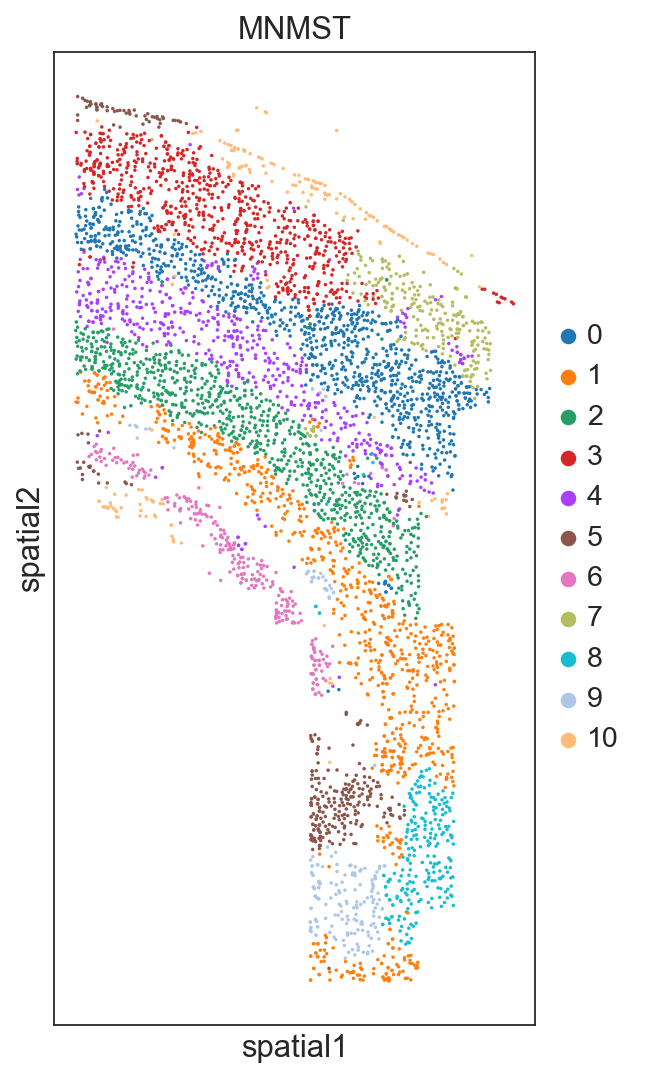

In [13]:
key_added = 'representation'
conns_key = 'representation'
dists_key = 'representation'

enhanced_data.uns[key_added] = {}
    
representation_dict = enhanced_data.uns[key_added]
    
representation_dict['connectivities_key'] = conns_key
representation_dict['distances_key'] = dists_key
representation_dict['var_names_use'] = enhanced_data.var_names.to_numpy()
    
representation_dict['params'] = {}
representation_dict['params']['method'] = 'umap'
enhanced_data.obsp['representation'] = Z_gpu
sc.tl.leiden(enhanced_data, neighbors_key='representation', resolution=1, key_added='MNMST_GPU')
print(enhanced_data.obs['MNMST_GPU'])
sc.pl.embedding(enhanced_data, basis='spatial', color=['MNMST_GPU'], show=False, size=10, title='MNMST')
plt.gca().set_aspect('equal', adjustable='box')

In [14]:
from sklearn.metrics import adjusted_rand_score
# we remove the "Excluded" part
adata_valid = enhanced_data[enhanced_data.obs['Region']!='Excluded']
cur_ari = adjusted_rand_score(adata_valid.obs['MNMST_GPU'], adata_valid.obs['Region'])
cur_ari

0.6075785507181172